In [49]:
# 파일 링크: https://github.com/e9t/nsmc/
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. 데이터 전처리

In [50]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [51]:
print('Train data size: ', len(train_data))
print('Test data size: ', len(test_data))

Train data size:  150000
Test data size:  50000


In [52]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [53]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [54]:
train_data['document'].nunique()

146182

In [55]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [56]:
print(len(train_data))

146183


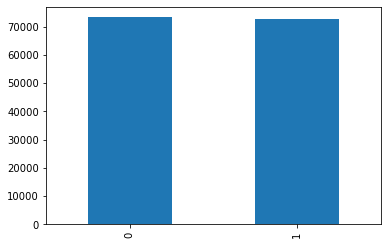

In [57]:
train_data['label'].value_counts().plot(kind='bar')

In [58]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [59]:
train_data.dropna(subset=['document'], inplace=True)

In [60]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [61]:
train_data['document'] = train_data['document'].str.replace(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
train_data['document'].replace('', np.nan, inplace=True)
train_data.dropna(subset=['document'], inplace=True)

<ipython-input-61-c1dd9bc70bf8>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')


In [62]:
train_data.loc[train_data['document'].isnull()]

,id,document,label


In [63]:
print(len(train_data))

145791


In [64]:
# 테스트 데이터도 전처리
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
test_data['document'] = test_data['document'].str.replace('^ +', '')
test_data['document'].replace('', np.nan, inplace=True)
test_data.dropna(subset=['document'], inplace=True)

<ipython-input-64-165303ded66d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
<ipython-input-64-165303ded66d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', '')


#### 토큰화

In [65]:
# 불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [68]:
# Okt 형태소 분석기 사용.
# 한국어 토큰화 할때는 영어처럼 띄어쓰기 기준이 아니라, 형태소 분석기를 사용한다.
# stem=True 속성을 주면 정규화를 수행한다.
okt = Okt()
okt.morphs('와 더빙 진짜 짜증나네요 목소리', stem=True)

['오다', '더빙', '진짜', '짜증나다', '목소리']

In [69]:
X_train = []

for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if word not in stopwords]
    X_train.append(temp_X)

In [70]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [71]:
X_test = []

for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if word not in stopwords]
    X_test.append(temp_X)

#### 정수 인코딩

In [72]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [128]:
#print(tokenizer.word_index)

In [74]:
threshold = 3
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [77]:
# 전체 단어 개수 중 빈도수 2이하인 단어 제거
# 0번 패딩 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('Vocab size: ', vocab_size)

Vocab size:  19416


In [78]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [79]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [80]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

#### 빈 샘플 제거

In [83]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence)<1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

145162
145162


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


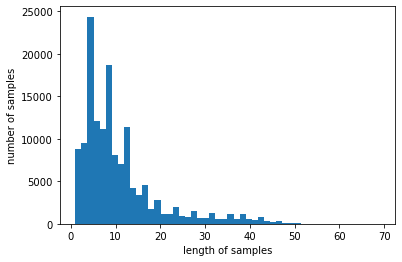

In [84]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 패딩

In [98]:
max_len = 30

In [85]:
# 패딩 길이는 30으로 맞춤
X_train = pad_sequences(X_train, maxlen=30)
X_test = pad_sequences(X_test, maxlen=30)

### 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [87]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [91]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)
                

Epoch 1/10
1936/1936 [==============================] - 80s 41ms/step - loss: 0.3908 - accuracy: 0.8235 - val_loss: 0.3531 - val_accuracy: 0.8456
Epoch 2/10
1936/1936 [==============================] - 74s 38ms/step - loss: 0.3276 - accuracy: 0.8577 - val_loss: 0.3336 - val_accuracy: 0.8554
Epoch 3/10
1936/1936 [==============================] - 73s 38ms/step - loss: 0.3013 - accuracy: 0.8720 - val_loss: 0.3312 - val_accuracy: 0.8598
Epoch 4/10
1936/1936 [==============================] - 74s 38ms/step - loss: 0.2831 - accuracy: 0.8822 - val_loss: 0.3268 - val_accuracy: 0.8604
Epoch 5/10
1936/1936 [==============================] - 75s 39ms/step - loss: 0.2681 - accuracy: 0.8903 - val_loss: 0.3266 - val_accuracy: 0.8601
Epoch 6/10
1936/1936 [==============================] - 76s 39ms/step - loss: 0.2534 - accuracy: 0.8973 - val_loss: 0.3434 - val_accuracy: 0.8590
Epoch 7/10
1936/1936 [==============================] - 77s 40ms/step - loss: 0.2387 - accuracy: 0.9043 - val_loss: 0.3394 -

In [93]:
#loaded_model = load_model('best_model.h5')
print(model.evaluate(X_test, y_test))

1527/1527 [==============================] - 9s 6ms/step - loss: 0.3861 - accuracy: 0.8386
[0.3860657215118408, 0.8386145830154419]


### 3. 리뷰 예측

In [122]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True)
    new_sentence = [word for word in new_sentence if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    padded = pad_sequences(encoded, maxlen=max_len)
    
    score = float(model.predict(padded))
    
    if score > 0.5:
        print(f'{round(score*100, 2)}% 확률로 긍정 리뷰입니다.')
    else:
        print(f'{round((1-score)*100, 2)}% 확률로 부정 리뷰입니다.')

In [123]:
sentiment_predict('영화 노잼이야')

99.18% 확률로 부정 리뷰입니다.


In [124]:
sentiment_predict('마블의 새로운 시작이다… 재밌어요')

96.14% 확률로 긍정 리뷰입니다.


In [125]:
sentiment_predict('마블 계급장 떼고 봐도 이건 진짜 역대급 영화임.. 스토리 좋았고 특히나 영상미는 미친 퀄리티임 진짜.')

98.92% 확률로 긍정 리뷰입니다.


In [126]:
sentiment_predict(' 액션은 확실히 엄청났다.하지만 영화는 액션이 전부가 아니다스토리가 어설프니 개연성이 부족하고, 개연성이 부족하니 영화에 몰입할 수 없다.이는 곧 영화가 노잼이라는 걸 의미한다.감상포인트를 하나 강제로 선택해야 하기에...')

99.95% 확률로 부정 리뷰입니다.


In [127]:
sentiment_predict(' 전형적인 서양에서 생각하는 온갖 동양 클리셰는 몽따 넣은 영화 .. 보면서 불편')

97.88% 확률로 부정 리뷰입니다.
